In [36]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats.stats import ttest_ind
from scipy.stats import boxcox

from sklearn.preprocessing import normalize
import math

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sqlalchemy import create_engine

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression


# Your goal in this challenge is to find the factors that affect life expectancy. Specifically, you need to find out which factors increase the expected life in the countries and which factors decrease it.

## 1. First, load the dataset.

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df = pd.read_sql_query('select * from lifeexpectancy', con=engine)

df2 = df.copy()

engine.dispose()

df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


## 2. Detect the problems with the data, such as missing values and outliers. Are there any nonsense values that seem to be stemmed from the data collection? For the missing values, discuss which technique would be the most suitable for filling out these values. Regarding the outliers, discuss their potential effects on your analysis and select an appropriate method to deal with them.

### Null Values

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

In [4]:
# Drop any rows that do not have a value for life expectancy 
df = df.dropna(subset=["Life expectancy "])

In [5]:
# see where the nulls are
df.isna().mean().sort_values()

Country                            0.000000
Year                               0.000000
Status                             0.000000
Life expectancy                    0.000000
Adult Mortality                    0.000000
infant deaths                      0.000000
percentage expenditure             0.000000
Measles                            0.000000
 HIV/AIDS                          0.000000
under-five deaths                  0.000000
Polio                              0.006489
Diphtheria                         0.006489
 thinness 5-9 years                0.010929
 thinness  1-19 years              0.010929
 BMI                               0.010929
Income composition of resources    0.054645
Schooling                          0.054645
Alcohol                            0.065915
Total expenditure                  0.077186
GDP                                0.151298
Hepatitis B                        0.188866
Population                         0.219945
dtype: float64

In [6]:
df.columns

Index(['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling'],
      dtype='object')

In [7]:
# Rename for clealniess and ease of use
df.rename(columns={"Life expectancy ": "life expectancy", " HIV/AIDS": "HIV", "Measles ": "Measles", " BMI ": "BMI", 
                  "under-five deaths ": "under 5 deaths", "Diphtheria ": "diphtheria", " thinness  1-19 years": "thinness 1-19",
                  " thinness 5-9 years": "thinness 5-9"}, inplace=True)

In [8]:
#df.info()

In [9]:
# Isolate columns with nulls to be filled 
fill_cols = ['Alcohol', 'Hepatitis B', 'BMI', 'Polio', 'Total expenditure', 'diphtheria', 
             'GDP', 'Population', 'thinness 1-19', 'thinness 5-9', 'Income composition of resources', 'Schooling']

In [10]:
# use interpolation to fill null values 
for column in fill_cols:
    df.loc[:, column] = df.loc[:, column].interpolate(limit_direction='both')

In [11]:
# No longer any Null values
# df.info()

### Outliers 

In [12]:
df.columns

Index(['Country', 'Year', 'Status', 'life expectancy', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles', 'BMI', 'under 5 deaths', 'Polio', 'Total expenditure',
       'diphtheria', 'HIV', 'GDP', 'Population', 'thinness 1-19',
       'thinness 5-9', 'Income composition of resources', 'Schooling'],
      dtype='object')

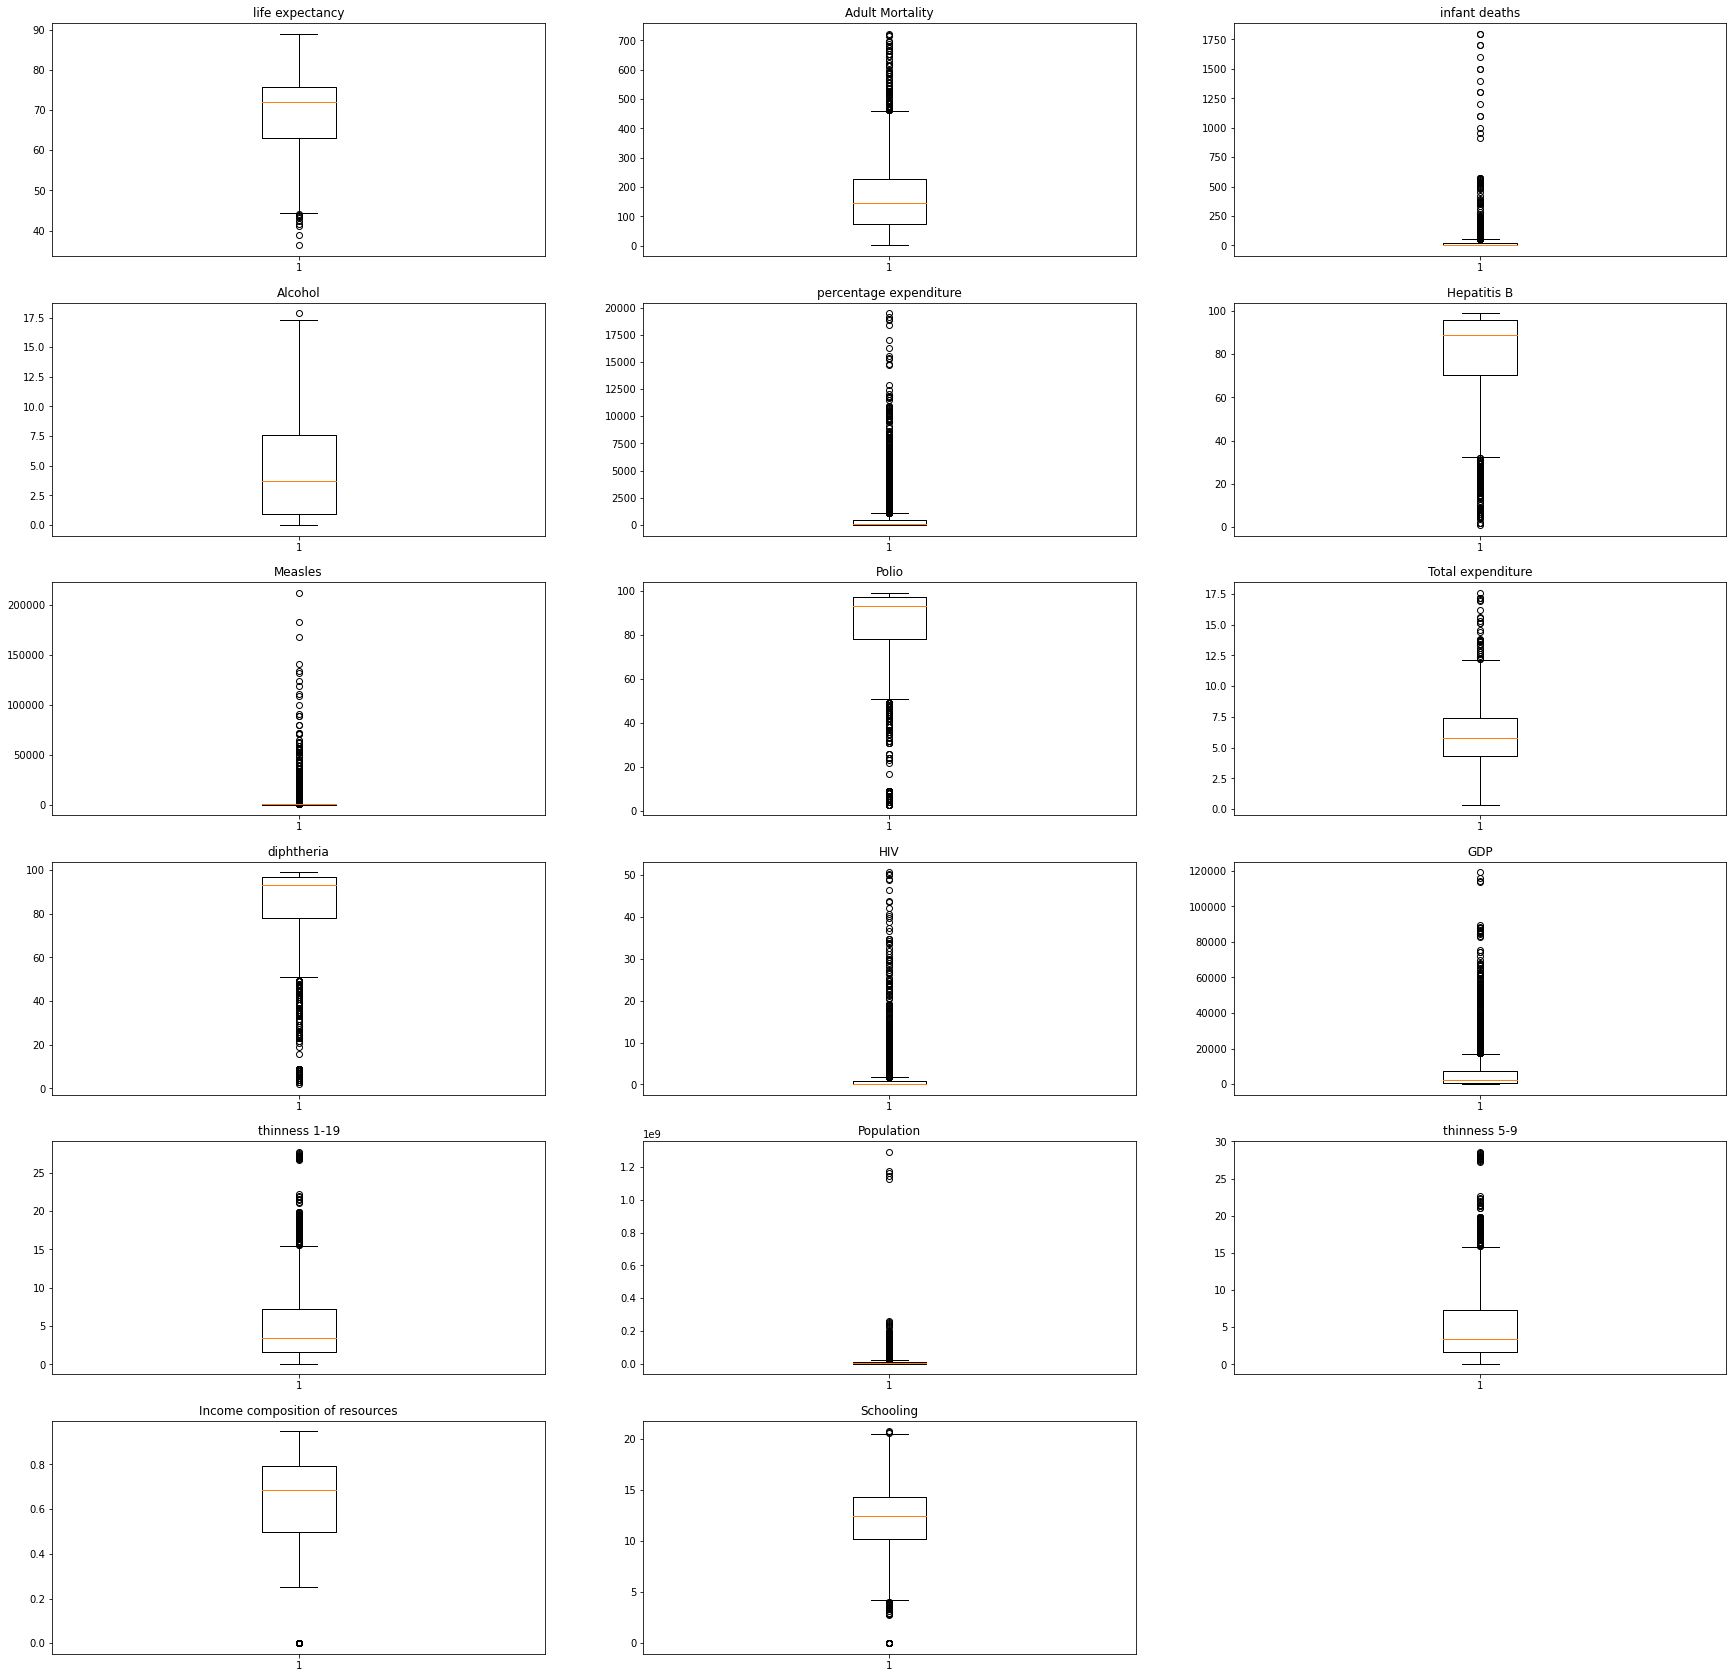

In [13]:
# Make box plots to visualize outliers 
plt.figure(figsize = (30, 30))
plt.subplot(6, 3, 1)
plt.boxplot(df['life expectancy'])
plt.title("life expectancy")

plt.subplot(6, 3, 2)
plt.boxplot(df['Adult Mortality'])
plt.title("Adult Mortality")

plt.subplot(6, 3, 3)
plt.boxplot(df['infant deaths'])
plt.title("infant deaths")

plt.subplot(6, 3, 4)
plt.boxplot(df['Alcohol'])
plt.title("Alcohol")

plt.subplot(6, 3, 5)
plt.boxplot(df['percentage expenditure'])
plt.title("percentage expenditure")

plt.subplot(6, 3, 6)
plt.boxplot(df['Hepatitis B'])
plt.title("Hepatitis B")

plt.subplot(6, 3, 7)
plt.boxplot(df['Measles'])
plt.title("Measles")

plt.subplot(6, 3, 8)
plt.boxplot(df['Polio'])
plt.title("Polio")

plt.subplot(6, 3, 9)
plt.boxplot(df['Total expenditure'])
plt.title("Total expenditure")

plt.subplot(6, 3, 10)
plt.boxplot(df['diphtheria'])
plt.title("diphtheria")

plt.subplot(6, 3, 11)
plt.boxplot(df['HIV'])
plt.title("HIV")

plt.subplot(6, 3, 12)
plt.boxplot(df['GDP'])
plt.title("GDP")

plt.subplot(6, 3, 13)
plt.boxplot(df['thinness 1-19'])
plt.title("thinness 1-19")

plt.subplot(6, 3, 14)
plt.boxplot(df['Population'])
plt.title("Population")

plt.subplot(6, 3, 15)
plt.boxplot(df['thinness 5-9'])
plt.title("thinness 5-9")

plt.subplot(6, 3, 16)
plt.boxplot(df['Income composition of resources'])
plt.title("Income composition of resources")


plt.subplot(6, 3, 17)
plt.boxplot(df['Schooling'])
plt.title("Schooling")
plt.show()

In [14]:
df.columns

Index(['Country', 'Year', 'Status', 'life expectancy', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles', 'BMI', 'under 5 deaths', 'Polio', 'Total expenditure',
       'diphtheria', 'HIV', 'GDP', 'Population', 'thinness 1-19',
       'thinness 5-9', 'Income composition of resources', 'Schooling'],
      dtype='object')

In [15]:
# Isolate columns with right skew to apply log
skew_cols = ['HIV', 'under 5 deaths', 'Population', 'GDP', 'percentage expenditure', 'Measles', "thinness 5-9", 'infant deaths', 'Adult Mortality']

In [16]:
# Since values have 0, add 1 to log to avoid log(0)
df[skew_cols] = np.log(df[skew_cols] + 1)

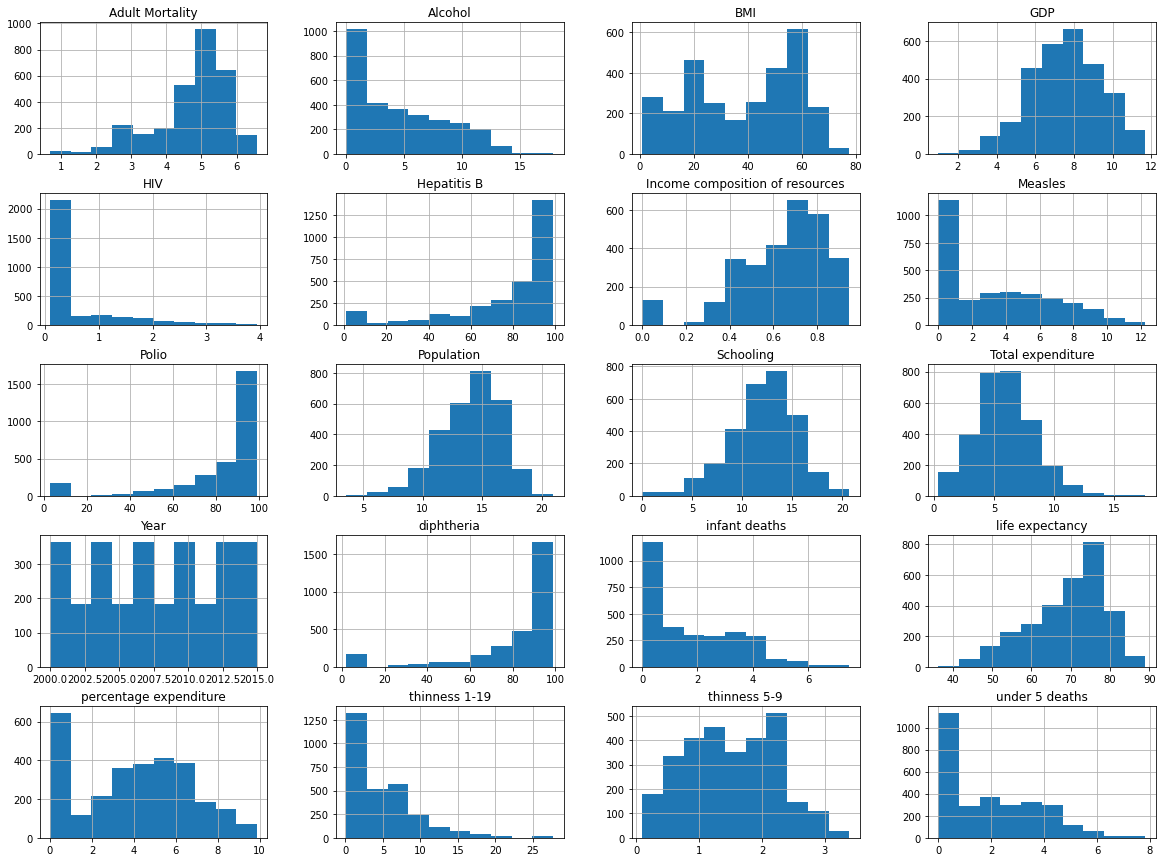

In [17]:
df.hist(figsize=(20, 15))
plt.show()

In [18]:
# ICR has 0 values that I want to drop
df = df[df['Income composition of resources'] > 0]

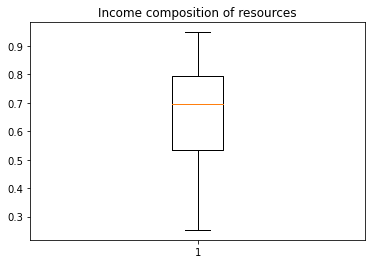

In [19]:
# No more ICR 0 values
plt.boxplot(df['Income composition of resources'])
plt.title("Income composition of resources")
plt.show()

## 3. Explore the data using univariate and multivariate exploration techniques. Be sure to pay special attention to your target variable. In this regard, focus on finding the relevant variables that may affect life expectancy.

In [20]:
df.head()

,Country,Year,Status,life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,diphtheria,HIV,GDP,Population,thinness 1-19,thinness 5-9,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,5.575949,4.143135,0.01,4.280542,65.0,7.051856,...,6.0,8.16,65.0,0.09531,6.372055,17.334091,17.2,2.906901,0.479,10.1
1,Afghanistan,2014,Developing,59.9,5.605802,4.174387,0.01,4.311116,62.0,6.200509,...,58.0,8.18,62.0,0.09531,6.419501,12.699497,17.5,2.917771,0.476,10.0
2,Afghanistan,2013,Developing,59.9,5.594711,4.204693,0.01,4.307023,64.0,6.066108,...,62.0,8.13,64.0,0.09531,6.450067,17.272826,17.7,2.928524,0.470,9.9
3,Afghanistan,2012,Developing,59.5,5.609472,4.248495,0.01,4.371777,67.0,7.933080,...,67.0,8.52,67.0,0.09531,6.508708,15.123021,17.9,2.944439,0.463,9.8
4,Afghanistan,2011,Developing,59.2,5.620401,4.276666,0.01,2.091507,68.0,8.011023,...,68.0,7.87,68.0,0.09531,4.167242,14.906964,18.2,2.954910,0.454,9.5


In [21]:
df.columns

Index(['Country', 'Year', 'Status', 'life expectancy', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles', 'BMI', 'under 5 deaths', 'Polio', 'Total expenditure',
       'diphtheria', 'HIV', 'GDP', 'Population', 'thinness 1-19',
       'thinness 5-9', 'Income composition of resources', 'Schooling'],
      dtype='object')

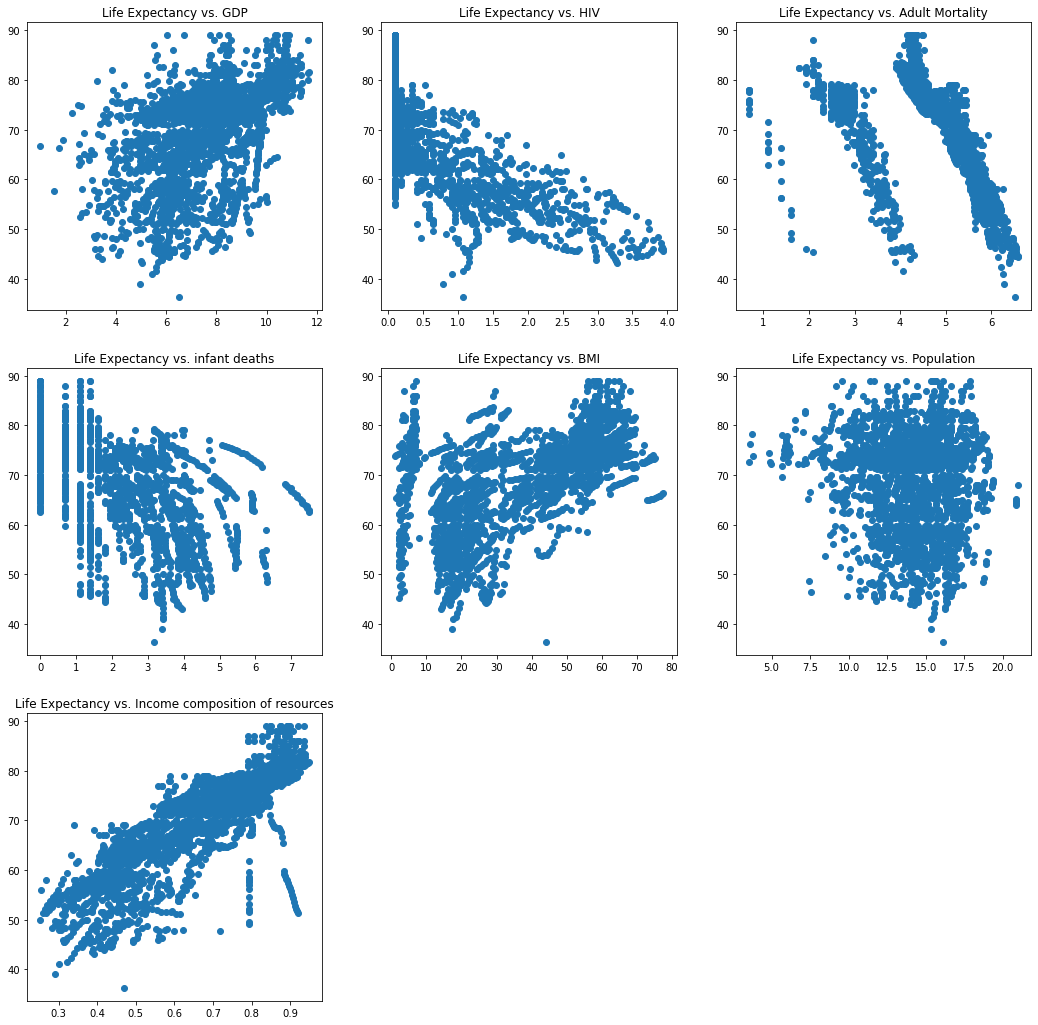

In [22]:
plt.figure(figsize=(18,18))

plt.subplot(3,3,1)
plt.scatter("GDP", "life expectancy", data=df)
plt.title("Life Expectancy vs. GDP")

plt.subplot(3, 3, 2)
plt.scatter("HIV", "life expectancy", data=df)
plt.title("Life Expectancy vs. HIV")

plt.subplot(3,3,3)
plt.scatter("Adult Mortality", "life expectancy", data=df)
plt.title("Life Expectancy vs. Adult Mortality")

plt.subplot(3,3,4)
plt.scatter("infant deaths", "life expectancy", data=df)
plt.title("Life Expectancy vs. infant deaths")

plt.subplot(3,3,5)
plt.scatter("BMI", "life expectancy", data=df)
plt.title("Life Expectancy vs. BMI")

plt.subplot(3,3,6)
plt.scatter("Population", "life expectancy", data=df)
plt.title("Life Expectancy vs. Population")

plt.subplot(3,3,7)
plt.scatter("Income composition of resources", "life expectancy", data=df)
plt.title("Life Expectancy vs. Income composition of resources")


plt.show()

In [23]:
df.drop(columns=['Alcohol', 'Hepatitis B', 'Measles'])

,Country,Year,Status,life expectancy,Adult Mortality,infant deaths,percentage expenditure,BMI,under 5 deaths,Polio,Total expenditure,diphtheria,HIV,GDP,Population,thinness 1-19,thinness 5-9,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,5.575949,4.143135,4.280542,19.1,4.430817,6.0,8.16,65.0,0.095310,6.372055,17.334091,17.2,2.906901,0.479,10.1
1,Afghanistan,2014,Developing,59.9,5.605802,4.174387,4.311116,18.6,4.465908,58.0,8.18,62.0,0.095310,6.419501,12.699497,17.5,2.917771,0.476,10.0
2,Afghanistan,2013,Developing,59.9,5.594711,4.204693,4.307023,18.1,4.499810,62.0,8.13,64.0,0.095310,6.450067,17.272826,17.7,2.928524,0.470,9.9
3,Afghanistan,2012,Developing,59.5,5.609472,4.248495,4.371777,17.6,4.543295,67.0,8.52,67.0,0.095310,6.508708,15.123021,17.9,2.944439,0.463,9.8
4,Afghanistan,2011,Developing,59.2,5.620401,4.276666,2.091507,17.2,4.584967,68.0,7.87,68.0,0.095310,4.167242,14.906964,18.2,2.954910,0.454,9.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,Zimbabwe,2004,Developing,44.3,6.584791,3.332205,0.000000,27.1,3.761200,67.0,7.13,65.0,3.543854,6.121103,16.363197,9.4,2.341806,0.407,9.2
2934,Zimbabwe,2003,Developing,44.5,6.573680,3.295837,0.000000,26.7,3.737670,7.0,6.52,68.0,3.629660,6.118870,16.351894,9.8,2.388763,0.418,9.5
2935,Zimbabwe,2002,Developing,44.8,4.304065,3.258097,0.000000,26.3,3.713572,73.0,6.53,71.0,3.708682,4.066431,11.740268,1.2,0.832909,0.427,10.0
2936,Zimbabwe,2001,Developing,45.3,6.532334,3.258097,0.000000,25.9,3.688879,76.0,6.16,75.0,3.763523,6.309168,16.330475,1.6,0.993252,0.427,9.8


## 4. In the feature-engineering step, you need to select a suite of variables that you think would be ideal in the modeling phase. More concretely, you may discard some variables that are highly correlated with the other ones or the variables that you think are irrelevant with the life expectancy.

In [24]:
# Look at Correlation Matrix
life_expectancy_corr = df.corr()

#  Abslute Value of correlations for interpretation
abs_corr = life_expectancy_corr['life expectancy'].abs()

# keep columns where correlation is over .45
keep_cols = abs_corr[abs_corr > .45].index
keep_df = df[keep_cols]

abs_corr.sort_values()


Population                         0.063691
Year                               0.155223
Total expenditure                  0.209618
Hepatitis B                        0.248588
Measles                            0.330824
percentage expenditure             0.368997
Alcohol                            0.403416
Polio                              0.465084
Adult Mortality                    0.465576
diphtheria                         0.480361
thinness 1-19                      0.483888
GDP                                0.537696
BMI                                0.567052
thinness 5-9                       0.574208
infant deaths                      0.593747
under 5 deaths                     0.623142
Schooling                          0.728321
HIV                                0.768336
Income composition of resources    0.840258
life expectancy                    1.000000
Name: life expectancy, dtype: float64

In [25]:
# Check correlation of columns we still have
keep_df.corr().style.background_gradient()

,life expectancy,Adult Mortality,infant deaths,BMI,under 5 deaths,Polio,diphtheria,HIV,GDP,thinness 1-19,thinness 5-9,Income composition of resources,Schooling
life expectancy,1.000000,-0.465576,-0.593747,0.567052,-0.623142,0.465084,0.480361,-0.768336,0.537696,-0.483888,-0.574208,0.840258,0.728321
Adult Mortality,-0.465576,1.000000,0.287341,-0.297591,0.301849,-0.206777,-0.205568,0.365606,-0.255466,0.228855,0.297360,-0.388674,-0.326959
infant deaths,-0.593747,0.287341,1.000000,-0.488118,0.996234,-0.370287,-0.355172,0.361160,-0.429195,0.514430,0.502863,-0.591873,-0.549279
BMI,0.567052,-0.297591,-0.488118,1.000000,-0.505018,0.292329,0.290044,-0.422281,0.389076,-0.531729,-0.567916,0.578809,0.533649
under 5 deaths,-0.623142,0.301849,0.996234,-0.505018,1.000000,-0.382314,-0.368349,0.392325,-0.441423,0.521143,0.512965,-0.617390,-0.570332
Polio,0.465084,-0.206777,-0.370287,0.292329,-0.382314,1.000000,0.667379,-0.319020,0.264659,-0.226257,-0.217299,0.440828,0.411422
diphtheria,0.480361,-0.205568,-0.355172,0.290044,-0.368349,0.667379,1.000000,-0.332349,0.251019,-0.239355,-0.228613,0.430248,0.402670
HIV,-0.768336,0.365606,0.361160,-0.422281,0.392325,-0.319020,-0.332349,1.000000,-0.333208,0.300227,0.376787,-0.568813,-0.441127
GDP,0.537696,-0.255466,-0.429195,0.389076,-0.441423,0.264659,0.251019,-0.333208,1.000000,-0.352939,-0.404750,0.678893,0.602176
thinness 1-19,-0.483888,0.228855,0.514430,-0.531729,0.521143,-0.226257,-0.239355,0.300227,-0.352939,1.000000,0.873905,-0.520945,-0.496681


In [26]:
# Keeping School over ICR because I want to interpret it
# Keeping under 5 deaths  over infant deaths because ...
# Keeping Thinness 1-19 over Thinness 5-9, because...

drop_cols = ['infant deaths', 'Income composition of resources', 'thinness 1-19']

keep_df = df.drop(columns=drop_cols)

In [27]:
keep_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2798 entries, 0 to 2937
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Country                 2798 non-null   object 
 1   Year                    2798 non-null   int64  
 2   Status                  2798 non-null   object 
 3   life expectancy         2798 non-null   float64
 4   Adult Mortality         2798 non-null   float64
 5   Alcohol                 2798 non-null   float64
 6   percentage expenditure  2798 non-null   float64
 7   Hepatitis B             2798 non-null   float64
 8   Measles                 2798 non-null   float64
 9   BMI                     2798 non-null   float64
 10  under 5 deaths          2798 non-null   float64
 11  Polio                   2798 non-null   float64
 12  Total expenditure       2798 non-null   float64
 13  diphtheria              2798 non-null   float64
 14  HIV                     2798 non-null   

In [28]:
# Isolate columns that are not useful for modeling 
useless_cols = ['Year', 'Country', 'Status']

keep_df = keep_df.drop(columns=useless_cols)
keep_df.head()

,life expectancy,Adult Mortality,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under 5 deaths,Polio,Total expenditure,diphtheria,HIV,GDP,Population,thinness 5-9,Schooling
0,65.0,5.575949,0.01,4.280542,65.0,7.051856,19.1,4.430817,6.0,8.16,65.0,0.09531,6.372055,17.334091,2.906901,10.1
1,59.9,5.605802,0.01,4.311116,62.0,6.200509,18.6,4.465908,58.0,8.18,62.0,0.09531,6.419501,12.699497,2.917771,10.0
2,59.9,5.594711,0.01,4.307023,64.0,6.066108,18.1,4.499810,62.0,8.13,64.0,0.09531,6.450067,17.272826,2.928524,9.9
3,59.5,5.609472,0.01,4.371777,67.0,7.933080,17.6,4.543295,67.0,8.52,67.0,0.09531,6.508708,15.123021,2.944439,9.8
4,59.2,5.620401,0.01,2.091507,68.0,8.011023,17.2,4.584967,68.0,7.87,68.0,0.09531,4.167242,14.906964,2.954910,9.5


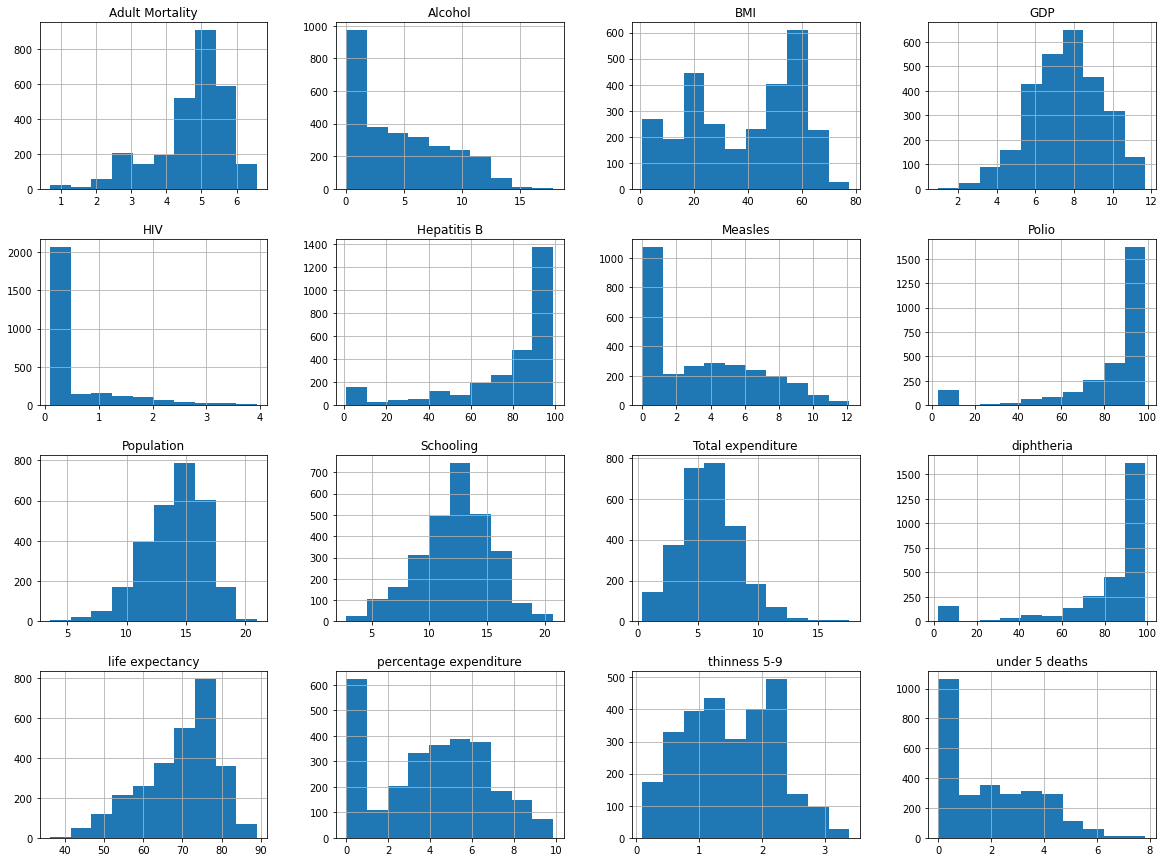

In [29]:
keep_df.hist(figsize=(20, 15))
plt.show()

In [30]:
keep_df.corr()

,life expectancy,Adult Mortality,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under 5 deaths,Polio,Total expenditure,diphtheria,HIV,GDP,Population,thinness 5-9,Schooling
life expectancy,1.000000,-0.465576,0.403416,0.368997,0.248588,-0.330824,0.567052,-0.623142,0.465084,0.209618,0.480361,-0.768336,0.537696,-0.063691,-0.574208,0.728321
Adult Mortality,-0.465576,1.000000,-0.157490,-0.228691,-0.107034,0.129782,-0.297591,0.301849,-0.206777,-0.121039,-0.205568,0.365606,-0.255466,0.032045,0.297360,-0.326959
Alcohol,0.403416,-0.157490,1.000000,0.283627,0.085625,-0.204781,0.336114,-0.406862,0.227328,0.305756,0.221154,-0.141212,0.411796,-0.022207,-0.476867,0.535199
percentage expenditure,0.368997,-0.228691,0.283627,1.000000,0.043502,-0.157493,0.260020,-0.345694,0.169470,0.106047,0.178897,-0.146557,0.467747,-0.047311,-0.296857,0.360758
Hepatitis B,0.248588,-0.107034,0.085625,0.043502,1.000000,-0.217422,0.191001,-0.256853,0.439922,0.096163,0.535466,-0.208081,0.121192,-0.034960,-0.100130,0.207793
Measles,-0.330824,0.129782,-0.204781,-0.157493,-0.217422,1.000000,-0.320997,0.622591,-0.253063,-0.161963,-0.252213,0.209173,-0.189298,0.241844,0.352441,-0.304311
BMI,0.567052,-0.297591,0.336114,0.260020,0.191001,-0.320997,1.000000,-0.505018,0.292329,0.231283,0.290044,-0.422281,0.389076,-0.030890,-0.567916,0.533649
under 5 deaths,-0.623142,0.301849,-0.406862,-0.345694,-0.256853,0.622591,-0.505018,1.000000,-0.382314,-0.192390,-0.368349,0.392325,-0.441423,0.336807,0.512965,-0.570332
Polio,0.465084,-0.206777,0.227328,0.169470,0.439922,-0.253063,0.292329,-0.382314,1.000000,0.135566,0.667379,-0.319020,0.264659,-0.041408,-0.217299,0.411422
Total expenditure,0.209618,-0.121039,0.305756,0.106047,0.096163,-0.161963,0.231283,-0.192390,0.135566,1.000000,0.145551,-0.068231,0.149481,-0.068525,-0.351411,0.253631


In [31]:
# Further filter columns to end up with 4-5 columns to use as features 
features = ['GDP', 'life expectancy', 'HIV', 'Schooling', 'BMI']

In [32]:
clean_df = keep_df[features]

clean_df.head()

,GDP,life expectancy,HIV,Schooling,BMI
0,6.372055,65.0,0.09531,10.1,19.1
1,6.419501,59.9,0.09531,10.0,18.6
2,6.450067,59.9,0.09531,9.9,18.1
3,6.508708,59.5,0.09531,9.8,17.6
4,4.167242,59.2,0.09531,9.5,17.2


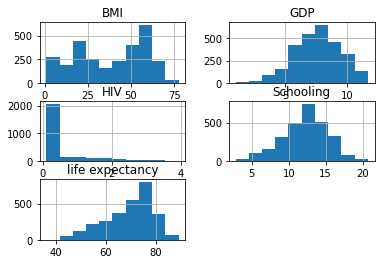

In [33]:
clean_df.hist()
plt.show()

## 5. Summarize your findings. One of the most important skills of a data scientist is to convey ideas and findings to nontechnical people using understandable language. In this regard, one of the most effective ways to communicate your ideas is to do it using effective visualization.


In [37]:
X = clean_df.drop(columns="life expectancy")
y = clean_df['life expectancy']

In [39]:
selector = SelectKBest(f_classif, k=2)

# Use `.fit()` method so the selector can 'learn' from our data
selector.fit(X, y)

# Use `.transform()` method so the selector can apply
# what it learned in `.fit()`
k_best = selector.transform(X)
k_best.shape

(2798, 2)

In [42]:
life_df = pd.DataFrame({"feature": X.columns, "f_score": selector.scores_})
life_df = life_df.sort_values("f_score", ascending=False)
print(life_df.head())

     feature    f_score
1        HIV  24.968672
2  Schooling  12.332042
0        GDP   5.043825
3        BMI   4.645788


Based on the model that I created, HIV prevalence is the bes indicator of having a high life expectancy, followed by HIV, Schooling, GDP, and BMI 